[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldomunaretto/immune_deep_learning/blob/main/notebooks/02_CNN/08_CNN_digit_recognition.ipynb)

# Convolutional Neural Networks

## Digit Recognition

---

<a id="index"></a>
## Index

* [Context](#section0)
* [MNIST dataset](#section1)
* [Load MNIST](#section2)
* [Baseline Model with MLP](#section3)
* [Simple CNN for the MNIST Dataset](#section4)
* [Deeper CNN for the MNIST Dataset](#section5)

---
<a id="section0"></a>
## Context

In this project, you will learn how to develop a Deep Learning model for the task of handwritten digit recognition using the MNIST dataset. After completing this lesson, you will know:
* How to load MNIST and develop a neural network model.
* How to implement and evaluate a baseline CNN for MNIST.
* How to implement an advanced Deep Learning model for MNIST.

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D
from keras import utils, Input
import matplotlib.pyplot as plt
%matplotlib inline

# Remove warning
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

---
<a id="section1"></a>
## MNIST dataset

MNIST consists of images of digits from a variety of scanned documents, normalized in size and centered.

Each image is given in black and white with $28 × 28$ pixels (784 pixels in total). 60,000 images are used to train a model and 10,000 images to validate it.

It is a digit recognition task. As such, there are 10 digits (0 to 9) or 10 classes to predict.

On Rodrigo Benenson's website, there is a list of the most advanced results and links to relevant articles on MNIST and other datasets.

More information about the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset

Information on MNIST results from [Rodrigo Benenson](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

---
<a id="section2"></a>
# Load MNIST

The dataset is automatically downloaded the first time this function is called and stored in your home directory at `~/.keras/datasets/mnist.pkl.gz` as a 15-megabyte file.

First, we will write a small script to download and visualize the first 4 images using the `mnist.load_data()` function.

In [ ]:
# split the data into training (60,000) and testing (10,000) data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

---
<a id="section3"></a>
## Baseline Model with MLP

We will use a classic MLP as a baseline for comparison with convolutional neural network models.

We import the classes, functions, and the MNIST dataset.

For a classic MLP, we need to reduce the images to a vector of pixels. In this case, the $28 × 28$ images will be input vectors of 784 pixels.

We perform this transformation using the `reshape()` function.

The pixel values are integers, so we convert them to floating-point to normalize them.

In [ ]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [ ]:
X_train

The pixel values are in a grayscale range between 0 and 255. We can normalize the pixel values in the range 0 to 1 by dividing each value by the maximum value, i.e., 255.

In [ ]:
# normalize inputs from 0-255 to 0-1
X_train = X_train/255
X_test = X_test/255

In [ ]:
X_train

Finally, the output variable is an integer from 0 to 9. Therefore, we will use One-Hot Encoding to transform the vector of class integers into a binary matrix.

We will use the Keras function `np_utils.to_categorical()` for this.

In [ ]:
# one hot encode outputs
num_classes = 10
y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_test = utils.to_categorical(y_test, num_classes=num_classes)

Let's define our model:
1. The number of inputs will be the maximum pixel size (784).
2. It will have a hidden layer with the same number of neurons as inputs (784).
3. A ReLU activation function will be used in the hidden layer.
4. A Softmax activation function will be used in the output layer.
5. The loss function will be `categorical_crossentropy`.
6. We will use ADAM to learn the weights.




<img src="https://github.com/aldomunaretto/immune_deep_learning/blob/main/image/notebook/baselineMLP.png" alt="baselineMLP" border="0" width="400" height="500">

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential(
         [
              Input(shape=(num_pixels,)),
              Dense(num_pixels, activation='relu'),
              Dense(num_classes, activation='softmax')
         ]
    )
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
    return model

We train and evaluate the model.
1. The model is fitted over 10 epochs with updates every 200 images.
2. The test data is used as the validation dataset.
3. A `verbose` value of 2 is used.
4. We evaluate on the test set and print the metrics.

In [ ]:
# build the model
model = baseline_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Error of the Baseline Model: %.2f%%" % (100-scores[1]*100))

---
<a id="section4"></a>
## Simple CNN for the MNIST Dataset

Now that we have seen how to load the MNIST dataset and train a simple multilayer perceptron model on it, it is time to develop a more sophisticated convolutional neural network or CNN model.

We will create a simple CNN for MNIST that demonstrates how to use all aspects of a modern CNN implementation, including convolutional layers, pooling layers, and dropout layers

In Keras, the layers used for two-dimensional convolutions expect pixel values with dimensions `[samples]-[width]-[height]-[channels]`

As for the channel in MNIST, since it is given in grayscale, the pixel dimension is set to 1.

In [ ]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][width][height][channels]
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')

We normalize the pixel values in the range 0 to 1 and perform OHE on the target.

In [ ]:
# normalize inputs from 0-255 to 0-1
X_train = X_train/255
X_test = X_test/255

# one hot encode outputs
numero_clases = 10
y_train = utils.to_categorical(y_train, num_classes=numero_clases)
y_test = utils.to_categorical(y_test, num_classes=numero_clases)

Next, we define our neural network model:
1. The first hidden layer is a convolutional layer called `Conv2D`.
    * It has 32 feature maps, with a size of $5 × 5$ and a ReLU activation function.
2. Pooling layer `MaxPooling2D`.
    * Patch size of $2 × 2$.
3. Regularization layer `Dropout`.
4. Flatten layer to convert the 2D matrix into a vector (1D).
5. Dense layer with 128 neurons and ReLU activation function.
6. Output layer with 10 neurons for the 10 classes and a **Softmax** activation function.
7. Compilation with ADAM, logarithmic loss as the cost function, and Accuracy as the metric.

<img src="https://github.com/aldomunaretto/immune_deep_learning/blob/main/image/notebook/cnnTopology.png" alt="CNNtopology" border="0" width="400" height="500">

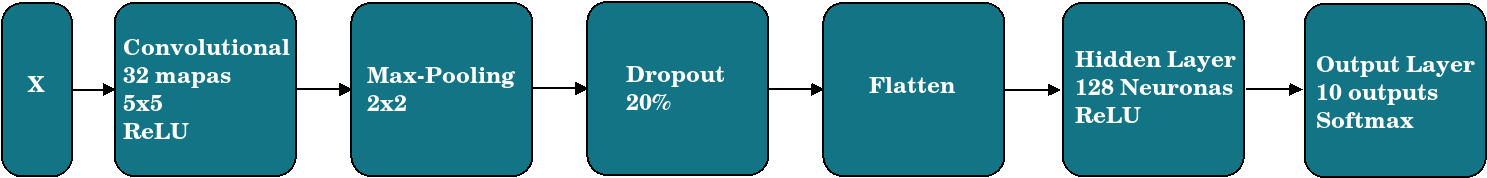

In [ ]:
# define a simple CNN model
def simple_model():
    # create model
   model = Sequential(
         [
              Input(shape=(28,28,1)),
              Conv2D(32, (5,5), activation='relu'),
              MaxPooling2D(),
              Dropout(0.2),
              Flatten(),
              Dense(128, activation='relu'),
              Dense(num_classes, activation='softmax')
         ]
   )
    # Compile model
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
   return model

We train with 10 epochs at a batch size of 200.

In [ ]:
# build the model
model = simple_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Error of the CNN Simple Model: %.2f%%" % (100-scores[1]*100))

---
<a id="section5"></a>
## Deeper CNN for the MNIST dataset

This time we define an architecture with more convolutional layers, Max-pooling, and fully connected layers.
1. Convolutional layer with 30 feature maps of size $5 × 5$.
2. Pooling layer with a patch size of $2 × 2$.
3. Convolutional layer with 15 feature maps of size $3 × 3$.
4. Pooling layer with a patch size of $2 × 2$.
5. Dropout layer with 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and ReLu activation.
8. Fully connected layer with 50 neurons and ReLu activation.
9. Output layer with Softmax activation.
10. Compilation with ADAM, logarithmic loss as the cost function, and Accuracy as the metric.

In [ ]:
def larger_model():
    # create model
    ???
    # Compile model
    ???
    return model

# build the model
???

# Fit the model
???

# Final evaluation of the model
???